In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import torchvision.utils as vutils
import torch.nn.functional as F
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchvision.models import vgg19
from skimage import io, transform
import warnings
warnings.filterwarnings("ignore")

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Dataset

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

def denorm(tensor, device='cpu'):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1,1,1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1,1,1).to(device)
    return torch.clamp(tensor * std + mean, 0, 1)

class StyleTransferDataset(Dataset):
    def __init__(self, content_dir, style_dir, crop_size=256, resized_size=512, transform=None):
        self.crop_size = crop_size
        self.resized_size = resized_size
        self.transform = transform


        self.content_resized = os.path.join('/kaggle/working', 'train2017_resized')
        self.style_resized   = os.path.join('/kaggle/working', 'images_resized')


        if not os.path.exists(self.content_resized):
            os.makedirs(self.content_resized, exist_ok=True)
            self._resize_folder(content_dir, self.content_resized)
        if not os.path.exists(self.style_resized):
            os.makedirs(self.style_resized, exist_ok=True)
            self._resize_folder(style_dir, self.style_resized, subfolders=True)

        self.content_images = glob.glob(os.path.join(self.content_resized, '*'))
        self.style_images = glob.glob(os.path.join(self.style_resized, '*', '*'))

        np.random.shuffle(self.content_images)
        np.random.shuffle(self.style_images)


        self.image_pairs = list(zip(self.content_images, self.style_images))

        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.RandomCrop(crop_size),
                transforms.ToTensor(),
                normalize
            ])

    def _resize_folder(self, src_dir, dst_dir, subfolders=False):
        print(f"Resizing images from {src_dir} -> {dst_dir}")
        if subfolders:
            for sub in os.listdir(src_dir):
                src_sub = os.path.join(src_dir, sub)
                dst_sub = os.path.join(dst_dir, sub)
                os.makedirs(dst_sub, exist_ok=True)
                for img_name in tqdm(os.listdir(src_sub)):
                    self._resize_image(os.path.join(src_sub, img_name), os.path.join(dst_sub, img_name))
        else:
            for img_name in tqdm(os.listdir(src_dir)):
                self._resize_image(os.path.join(src_dir, img_name), os.path.join(dst_dir, img_name))

    def _resize_image(self, src_path, dst_path):
        try:
            img = io.imread(src_path)
            if len(img.shape) != 3 or img.shape[2] != 3:
                return  # skip grayscale
            H, W, _ = img.shape
            if H < W:
                ratio = W / H
                H_new = self.resized_size
                W_new = int(ratio * H_new)
            else:
                ratio = H / W
                W_new = self.resized_size
                H_new = int(ratio * W_new)
            img_resized = transform.resize(img, (H_new, W_new), mode='reflect', anti_aliasing=True)
            io.imsave(dst_path, (img_resized * 255).astype(np.uint8))
        except:
            pass

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        content_path, style_path = self.image_pairs[idx]
        content_img = Image.open(content_path).convert('RGB')
        style_img = Image.open(style_path).convert('RGB')

        if self.transform:
            content_img = self.transform(content_img)
            style_img = self.transform(style_img)

        return content_img, style_img



## Architecture

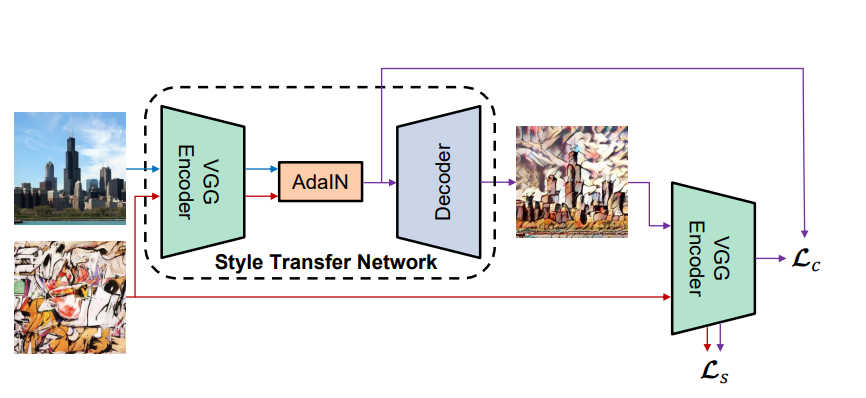

In [9]:
## Support function
def calc_mean_std(_feat):
    """
    input: feature params => [batch_size, c, h, w]
    output: feature params => [batch_size, c, 1, 1]
    """
    mean = _feat.mean([2,3], keepdim=True)
    std = _feat.std([2,3], keepdim=True)
    return mean, std
    

In [10]:
class VGG_encoder(nn.Module):
    def __init__(self, device='cuda'):
        super().__init__()
        vgg = vgg19(pretrained=True).features

        self.enc_1 = vgg[:2]     # relu1_1
        self.enc_2 = vgg[2:7]    # relu2_1
        self.enc_3 = vgg[7:12]   # relu3_1
        self.enc_4 = vgg[12:21]  # relu4_1
        for p in vgg.parameters():
            p.requires_grad = False

    def forward(self, x, last_only=False):
        h1 = self.enc_1(x)
        h2 = self.enc_2(h1)
        h3 = self.enc_3(h2)
        h4 = self.enc_4(h3)

        if last_only:
            return h4
        else:
            return (h1, h2, h3, h4)


In [11]:
def AdaIN_layer(content_feat, style_feat, eps = 1e-5):
    c_mean, c_std = calc_mean_std(content_feat)
    s_mean, s_std = calc_mean_std(style_feat)
    return s_std * (content_feat - c_mean)/(c_std+eps) + s_mean

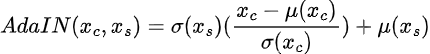
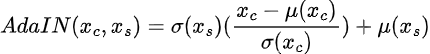

In [12]:
class RC(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, pad_size=1, activated = True):
        super().__init__()
        self.pad=nn.ReflectionPad2d((pad_size,pad_size,pad_size,pad_size))
        self.conv=nn.Conv2d(in_channels,out_channels,kernel_size)
        self.activated=activated

    def forward(self,x):
        h=self.pad(x)
        h=self.conv(h)
        if self.activated:
            return F.relu(h)
        return h
    

In [19]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.rc1=RC(512,256,3,1)
        self.rc2=RC(256,256,3,1)
        self.rc3=RC(256,256,3,1)
        self.rc4=RC(256,256,3,1)
        self.rc5=RC(256,128,3,1)
        self.rc6=RC(128,128,3,1)
        self.rc7=RC(128,64,3,1)
        self.rc8=RC(64,64,3,1)
        self.rc9=RC(64,3,3,1, False)

    def forward(self,features):
        h=self.rc1(features) 
        h=F.interpolate(h,scale_factor=2)
        h=self.rc2(h)
        h=self.rc3(h)
        h=self.rc4(h)
        h=self.rc5(h)
        h=F.interpolate(h, scale_factor=2)
        h=self.rc6(h)
        h=self.rc7(h)
        h=F.interpolate(h, scale_factor=2)
        h=self.rc8(h)
        h=self.rc9(h)
        return h

Full Model
- Vgg Encoder
- AdaIN
- Decoder

In [13]:
class Model(nn.Module):
    def __init__(self, device='cuda'):
        super().__init__()
        self.encoder = VGG_encoder().to(device)
        self.decoder = Decoder().to(device)

    def content_loss(self,out_feat, target_feat):
        return F.mse_loss(out_feat, target_feat)

    def style_loss(self, out_feat, style_feat):
        loss = 0
        for f_out, f_style in zip(out_feat, style_feat):
            out_mean, out_std = calc_mean_std(f_out)
            style_mean, style_std = calc_mean_std(f_style)

            loss += F.mse_loss(out_mean, style_mean)
            loss += F.mse_loss(out_std, style_std)

        return loss

    def generate(self, content_img, style_img, alpha = 1.0):
        #Encoder
        content_feat = self.encoder(content_img, True)
        style_feat = self.encoder(style_img, True)
    
        #AdaIN
        t = AdaIN_layer(content_feat, style_feat)
        t = alpha * t + (1-alpha)*content_feat
    
        #Decoder
        T = self.decoder(t)
        return T
        
    def forward(self, content_img, style_img, alpha = 1, lamb = 10):
        """
            content_img, style_img: [B,3,H,W] normalized
            alpha: blend factor
        """
        #Encoder
        content_feat = self.encoder(content_img, True)
        style_feat = self.encoder(style_img, True)
    
        #AdaIN
        t = AdaIN_layer(content_feat, style_feat)
        t = alpha * t + (1-alpha)*content_feat
    
        #Decoder
        T = self.decoder(t)

        #Encoder
        out_last = self.encoder(T, last_only=True)
        out_m_feat = self.encoder(T, last_only=False)
        style_m_feat = self.encoder(style_img, last_only=False)
        
        loss_c = self.content_loss(out_last, t)
        loss_s = self.style_loss(out_m_feat, style_m_feat)

        total_loss = loss_c + lamb * loss_s
        return total_loss

## Training

In [14]:
def train(model, loader, optimizer, epochs=100, device='cuda', save_dir="outputs", patience=10, log_file="train_log.txt"):
    os.makedirs(save_dir, exist_ok=True)

    log_f = open(os.path.join(save_dir, log_file), "w")

    def log(s):
        print(s)
        log_f.write(s + "\n")
        log_f.flush()

    model.train()

    best_loss = float('inf')
    best_epoch = -1
    epochs_no_improve = 0  

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (content, style) in enumerate(loader):
            content = content.to(device)
            style = style.to(device)

            loss = model(content, style)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 20 == 0:
                log(f"Epoch [{epoch+1}/{epochs}], Step [{i}/{len(loader)}], Loss: {loss.item():.4f}")

        epoch_loss = running_loss / len(loader)
        log(f"Epoch [{epoch+1}/{epochs}] average loss: {epoch_loss:.4f}")

        # check improvement
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_epoch = epoch + 1
            epochs_no_improve = 0  # reset counter
            torch.save(model.state_dict(), f"{save_dir}/adain_best.pth")
            log(f"Saved best model at epoch {best_epoch} with loss {best_loss:.4f}")
        else:
            epochs_no_improve += 1
            log(f"No improvement for {epochs_no_improve} epoch(s)")

        # early stopping
        if epochs_no_improve >= patience:
            log(f"Early stopping at epoch {epoch+1} after {patience} epochs with no improvement.")
            break

        # save sample image
        with torch.no_grad():
            output = model.generate(content[0:1], style[0:1], alpha=1.0)
            output = denorm(output[0].cpu())
            sample_path = f"{save_dir}/epoch_{epoch+1}_sample.jpg"
            vutils.save_image(output, sample_path)
            log(f"Saved sample stylized image for epoch {epoch+1} at {sample_path}")

    log(f"Training finished. Best model saved at epoch {best_epoch} with loss {best_loss:.4f}")
    log_f.close()


# Start

In [ ]:
content_dir = "/kaggle/input/coco-2017-dataset/coco2017/train2017"
style_dir = "/kaggle/input/best-artworks-of-all-time/images/images"

In [ ]:
dataset = StyleTransferDataset(content_dir=content_dir, style_dir=style_dir)
loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)

In [ ]:
model = Model(device=device).to(device)
optimizer = torch.optim.Adam(model.decoder.parameters(), lr=1e-4)
train(model, loader, optimizer, epochs=200, device=device)

## Checking Output

Shape của ảnh: (256, 256, 3)


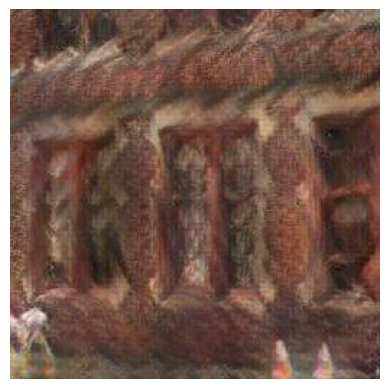

In [4]:
img_path = "/kaggle/input/output/outputs/epoch_40_sample.jpg"

img = Image.open(img_path)

img_array = np.array(img)
print("Shape:", img_array.shape)

plt.imshow(img_array)
plt.axis('off')
plt.show()

## Testing

In [15]:
model_path = "/kaggle/input/output/outputs/adain_best.pth"

In [23]:
def show(img_tensor):
    img = denorm(img_tensor.squeeze(0),device = 'cuda').permute(1,2,0).cpu().numpy()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [20]:
model = Model(device=device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

Model(
  (encoder): VGG_encoder(
    (enc_1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (enc_2): Sequential(
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
    )
    (enc_3): Sequential(
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
    (enc_4): Sequential(
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 2

In [42]:
transform = transforms.Compose([
    transforms.Resize((512,512)),  # resize cố định
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

content_path = "/kaggle/input/output/train2017_resized/000000000149.jpg"
style_path   = "/kaggle/input/output/images_resized/Georges_Seurat/Georges_Seurat_10.jpg"

content_img = transform(Image.open(content_path).convert('RGB')).unsqueeze(0).to(device)
style_img   = transform(Image.open(style_path).convert('RGB')).unsqueeze(0).to(device)


Content:


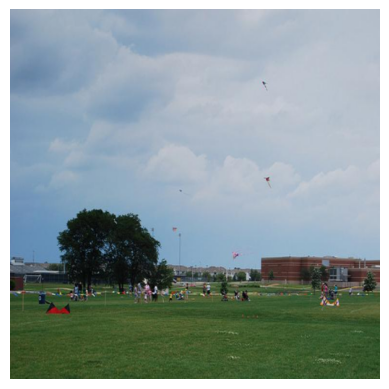

Style:


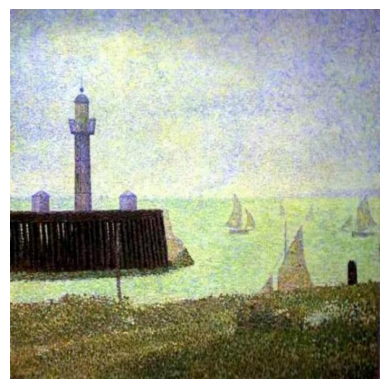

Output:


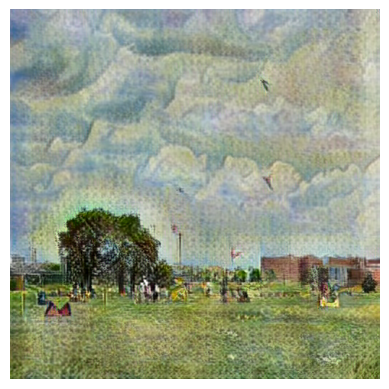

Output shape: torch.Size([1, 3, 512, 512])


In [43]:
with torch.no_grad():
    output = model.generate(content_img, style_img, alpha=1.0)

print("Content:")
show(content_img)
print("Style:")
show(style_img)
print("Output:")
show(output)
print("Output shape:", output.shape)


In [33]:
save_dir = "/kaggle/working/results"
os.makedirs(save_dir, exist_ok=True)

output_path = os.path.join(save_dir, "output_stylized.png")
vutils.save_image(denorm(output, device = 'cuda'), output_path)

print(f"Output saved to {output_path}")

Output saved to /kaggle/working/results/output_stylized.png
